In [1]:
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle

import os

Want array’s of  [list of particle 4-vectors(pt, mass, eta, phi), z_leading, theta] to feed into RNN

In [2]:
def partition_exp(n_particles=10, nevents=1, mu=1.):
    evals = np.random.exponential(scale = mu, size=(nevents,n_particles))
    sumRow =np.repeat(evals.sum(axis=1), n_particles).reshape(nevents, n_particles)
    evals = np.sort(np.divide(evals,sumRow))[:, ::-1]
    return evals

In [3]:
def makeFourVectors(n_data = 10, n_particles = 5, isSignal = False):
    if isSignal:
        theta = np.random.normal(loc=0.2, scale=0.02, size=n_data) # signal_d
        z = np.random.normal(loc=0.5, scale=0.02, size=n_data) #signal_z 
        labels = np.zeros(shape=(n_data,2))
        pt = np.random.exponential(scale = 1/0.01, size = n_data)
        mass = 0.936*np.random.normal(loc = 39.5, scale = 18.3, size = n_data)
        eta = 1.1*np.random.normal(loc = 0.0, scale = 1.4, size = n_data)
        phi = np.random.uniform(-3.14,3.14,n_data)
        labels[:,0] = 1
    else:
        theta = np.random.exponential(scale=0.02, size=n_data) # bkg_d
        z = np.random.exponential(scale=0.02, size=n_data) #bkg_z
        labels = np.zeros(shape=(n_data,2))
        pt = np.random.exponential(scale=1/0.002675, size=n_data)
        mass = np.random.exponential(scale=1/0.011082, size=n_data)
        eta = 1.008*np.random.normal(loc = 0.001913, scale = 1.811, size = n_data)
        phi = np.random.uniform(-3.14,3.14,n_data) #uniform distribution with a small variance (.1 and .2)                                                               
        labels[:,1] = 1
    
    # masking z to ensure z<1.0
    z = np.where(z<1.0, z, z%1) #signal_z   
    # making so that z is always more than 1-z
    z = np.where(z>0.5, z, (1-z))
    
    mass = np.where(mass>0., mass, mass+20.)
    
    z = np.repeat(z, n_particles).reshape(n_data, n_particles)
    # masking theta to ensure theta<0.5
    theta = np.where(theta<0.5, theta, theta%0.5)
    theta = np.repeat(theta, n_particles).reshape(n_data, n_particles)
    
    # distributing pT fractions between particles
    particles1 = np.multiply(partition_exp(n_particles, n_data), z)
    particles2 = np.multiply(partition_exp(n_particles, n_data), (1-z))
    
    
    # one jet has two subjets 
    radii = np.random.uniform(0.25,0.5 ,size = (n_data,2))
    radii1 = np.array([np.multiply(np.ones(shape = (n_particles)),y) for y in radii[:,0]])
    radii2 = np.array([np.multiply(np.ones(shape = (n_particles)),y) for y in radii[:,1]])
    dtheta1 = np.random.exponential(scale=0.5, size=(n_data, n_particles)) # delta theta for first subjet
    dtheta1= np.sort(np.where(dtheta1<radii1, dtheta1, dtheta1%radii1))
    phi1 = np.random.uniform(0, 2*math.pi, size=(n_data, n_particles)) # angular
    dtheta2 = np.random.exponential(scale=0.5, size=(n_data, n_particles)) # delta theta for second subjet
    dtheta2= np.sort(np.where(dtheta2<radii2, dtheta2, dtheta2%radii2))
    phi2 = np.random.uniform(0, 2*math.pi, size=(n_data, n_particles)) # angular
    
    z = z.reshape(n_data*n_particles,1)[::n_particles]
    theta = theta.reshape(n_data*n_particles,1)[::n_particles]

    return pt, eta, mass, phi, radii, z, theta, labels

Load some pythia data and fit to get idea of signal vs. background distribution to make a nice toy model

In [4]:
n_data = 10000
n_particles = 10
tic = time.perf_counter()
isSignal1 = True
pt1, eta1, mass1, phi1, radii1, z1, theta1, labels1 = makeFourVectors(n_data, n_particles, isSignal1)
fourvectors1 = np.array([pt1, eta1, mass1, phi1])
print(fourvectors1)
fourvectors1.reshape(n_data, 4, 1)
toc = time.perf_counter()
print('Processing Time is ',toc-tic, 'seconds for ',n_data, ' samples.' )
np.savez('data/dummyvectors_signal', fourvectors = fourvectors1, radiilab = radii1, zlab = z1, thetalab = theta1, labels = labels1)

[[ 1.90064978e+02  4.27845460e+01  1.70035238e+02 ...  9.97420345e+01
   2.94465859e+01  2.06066445e+02]
 [ 1.00196660e-02  2.04591297e+00 -1.81902279e-01 ... -1.78574381e+00
  -1.08418742e+00  6.22597665e-01]
 [ 5.61151711e+01  6.43907793e+01  5.04195039e+01 ...  1.19641603e+01
   2.37344327e+01  2.68217720e+01]
 [-1.46631729e+00 -1.50779250e+00 -1.21492400e+00 ... -2.02035250e+00
  -1.84062898e+00  4.23543869e-01]]
Processing Time is  0.127943578 seconds for  10000  samples.


In [5]:
tic = time.perf_counter()
isSignal2 = False
pt2, eta2, mass2, phi2, radii2, z2, theta2, labels2= makeFourVectors(n_data, n_particles, isSignal2)
toc = time.perf_counter()
fourvectors2 = np.array([pt2, eta2, mass2, phi2])
fourvectors2.reshape(n_data, 4, 1)
print('Processing Time is ',toc-tic, 'seconds for ',n_data, ' samples.' )
np.savez('data/dummyvectors_bkg', fourvectors = fourvectors2, radiilab = radii2, zlab = z2, thetalab = theta2, labels = labels2)

Processing Time is  0.11592594200000006 seconds for  10000  samples.


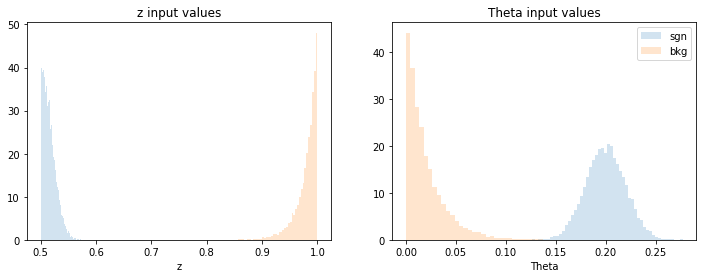

Text(0.5, 0, 'eta')

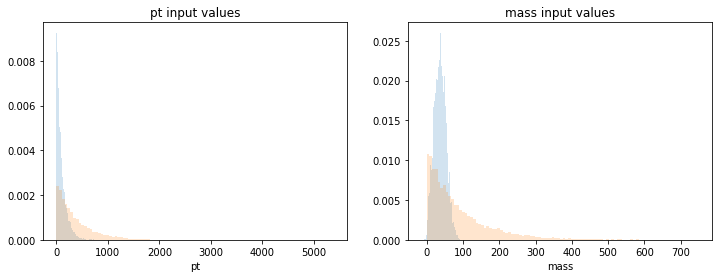

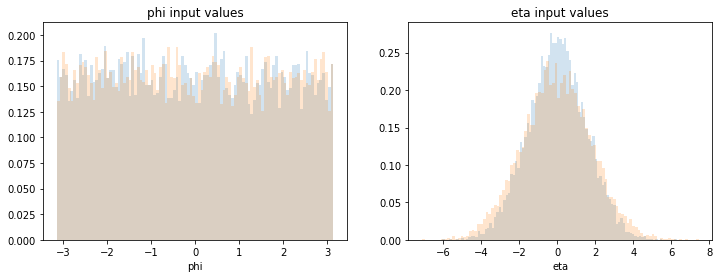

In [6]:
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.hist(z1, 50, density=True, histtype='stepfilled', alpha=0.2, label = "sgn")
plt.hist(z2, 50, density=True, histtype='stepfilled', alpha=0.2, label = "bkg")
plt.title("z input values")
plt.xlabel("z")
plt.subplot(1,2,2)
plt.hist(theta1, 50, density=True, histtype='stepfilled', alpha=0.2, label = "sgn")
plt.hist(theta2, 50, density=True, histtype='stepfilled', alpha=0.2, label = 'bkg')
plt.title("Theta input values")
plt.xlabel("Theta")
plt.legend()
plt.show()
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.hist(pt1, 100, density=True, histtype='stepfilled', alpha=0.2, label = "sgn")
plt.hist(pt2, 100, density=True, histtype='stepfilled', alpha=0.2, label = "bkg")
plt.title("pt input values")
plt.xlabel("pt")
plt.subplot(1,2,2)
plt.hist(mass1, 100, density=True, histtype='stepfilled', alpha=0.2, label = "sgn")
plt.hist(mass2, 100, density=True, histtype='stepfilled', alpha=0.2, label = "bkg")
plt.title("mass input values")
plt.xlabel("mass")
plt.figure(figsize = (12,4))
plt.subplot(1,2,1)
plt.hist(phi1, 100, density=True, histtype='stepfilled', alpha=0.2, label = "sgn")
plt.hist(phi2, 100, density=True, histtype='stepfilled', alpha=0.2, label = "bkg")
plt.title("phi input values")
plt.xlabel("phi")
plt.subplot(1,2,2)
plt.hist(eta1, 100, density=True, histtype='stepfilled', alpha=0.2, label = "sgn")
plt.hist(eta2, 100, density=True, histtype='stepfilled', alpha=0.2, label = "bkg")
plt.title("eta input values")
plt.xlabel("eta")

In [7]:
tic = time.perf_counter()
isSignal3 = True
pt3, eta3, mass3, phi3, radii3, z3, theta3, labels3= makeFourVectors(n_data, n_particles, isSignal3)
toc = time.perf_counter()
fourvectors3 = np.array([pt3, eta3, mass3, phi3])
fourvectors3.reshape(n_data, 4, 1)
print('Processing Time is ',toc-tic, 'seconds for ',n_data, ' samples.' )
np.savez('data/dummyvectors_sgn_test', fourvectors = fourvectors3, radiilab = radii3, zlab = z3, thetalab = theta3, labels = labels3)

Processing Time is  0.11810905699999985 seconds for  10000  samples.


In [8]:
tic = time.perf_counter()
isSignal4 = False
pt4, eta4, mass4, phi4, radii4, z4, theta4, labels4= makeFourVectors(n_data, n_particles, isSignal4)
toc = time.perf_counter()
fourvectors4 = np.array([pt4, eta4, mass4, phi4])
fourvectors4.reshape(n_data, 4, 1)
print('Processing Time is ',toc-tic, 'seconds for ',n_data, ' samples.' )
np.savez('data/dummyvectors_bkg_test', fourvectors = fourvectors4, radiilab = radii4, zlab = z4, thetalab = theta4, labels = labels4)

Processing Time is  0.11742425999999995 seconds for  10000  samples.


In [9]:
traindata_sig = np.load('data/dummyvectors_signal.npz')
traindata_bkg = np.load('data/dummyvectors_bkg.npz')
trainlabels = np.concatenate((traindata_sig['labels'],traindata_bkg['labels']),axis=0)
trainvectors = np.concatenate((traindata_sig['fourvectors'], traindata_bkg['fourvectors']),axis = 1)
trainradii = np.concatenate((traindata_sig['radiilab'], traindata_bkg['radiilab']), axis = 0)
traintheta = np.concatenate((traindata_sig['thetalab'], traindata_bkg['thetalab']), axis = 0)
trainz = np.concatenate((traindata_sig['zlab'], traindata_bkg['zlab']), axis = 0)
print(trainvectors.shape)

(4, 20000)
